# **Convolutional Neural Network (CNN)**


## Objective

1. Implement **Convolutional Neural Network(CNN)** using pytorch
2. Comparision between **Multi-Layer Perceptron (MLP)** and **CNN**



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary 

from tqdm import tqdm
import time 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

##**1.Convolutional Neural Network(CNN)**


- Convolutional layer can be defined by `torch.nn.Conv2d` 
- Convolutional layer needs different arguments from fully connected layer(nn.Linear)
  - FC layer needs **size of input feature** and **size of output feature** for arguments
  - Convolutional layer needs **a number of input channel** and **a number of output channel** similarly, but also it needs **size of kernel (filter)** 
- Convolutional layer utilizes different weight from FC layer
  - FC layer utilizes weight size of 2-dimentional matrix (*output feature size, input feature size*)
  - Convolutional layer utilizes weight size of  4-dimentional tensor (*output channel size, input channel size, kernel height, kernel width*)


In [ ]:
linear_layer = nn.Linear(in_features=784, out_features=400)
convolutional_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5))
print("Shape of Linear layer weight:" ,end=" ")
print(linear_layer.weight.shape)
print("Shape of Convolutional layer weight:", end=" ")
print(convolutional_layer.weight.shape)

Loading MNIST dataset using a package `torchvision`

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=200, shuffle=False)

These are functions for visualizing features of CNN. You don't have to look in detail.

In [ ]:
def vis_feat(f1, f2, inp):
  l = [f1, f2]
  fig, axes = plt.subplots(11, 8, figsize=(12.5,12.5))  
  plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace=0, hspace=0.1)
  ax = axes[0,0]
  ax.imshow(inp[0], cmap='gray_r')
  ax.set_title('Original image')    
  ax.axis('off') 
  
  for i in range(7):
    ax = axes[0,i+1]
    ax.axis('off')  

  for i in range(32):
      r = 2 + i // 8
      c = i % 8
      ax = axes[r, c]             
      ax.imshow(f1[i], cmap='gray_r')
      if i == 0:
        ax.set_title('Output from conv1')      
      ax.axis('off')
      if i < 8:
        ax = axes[1, i]
        ax.axis('off')

  for i in range(32):
    r = 7 + i // 8
    c = i % 8
    ax = axes[r, c]             
    ax.imshow(f2[i], cmap='gray_r')
    if i == 0:
      ax.set_title('Output from conv2')      
    ax.axis('off')
    if i < 8:
        ax = axes[6, i]
        ax.axis('off')

  plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
def vis(model, loader):
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      images, labels = data
      f1 = model.conv1(images)
      f2 = model.conv2(model.pool(F.relu(f1)))

      vis_feat(f1[0], f2[0], images[0])
      break   

### **1.1. Implement of CNN using pytorch**


Construct convolutional neural network below using `torch.nn.Conv2d`, `torch.nn.MaxPool2d`, and `torch.nn.Linear` 

* **Architecture 1**
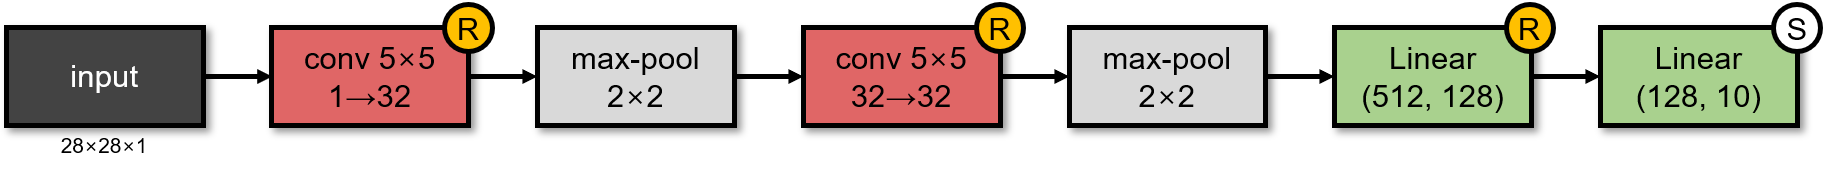

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Construct convolutional layer    
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5))
    # num of input channel = 1, num of output channel 32, kernel size = 5×5 
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max-pooling with kernel size = 2×2, stride = 2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
    # num of input channel = 1, num of output channel 32, kernel size = 5×5 (5 = 5×5)    
    
    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    batchsize = x.size(0)
    x = self.conv1(x) # output for feature visuallization
    x = self.pool(F.relu(x)) # Convolutional layer -> ReLU activation -> max_pooling
    x = self.conv2(x)
    x = self.pool(F.relu(x))
    x = x.view(batchsize,-1) # Change the shape of output from [batch_size, channels, height, width] to [batch_size, channels*height*width]
    x = F.relu(self.fc1(x))
    out = self.fc2(x)
    return out

Define a function `train` for train the model and `evaluate` for test the model and measure its accuracy  

In [ ]:
def train(model, n_epoch, loader, optimizer, criterion, device="cpu"):
  model.train()
  for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(input=outputs, target=labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Epoch {}, loss = {:.3f}'.format(epoch, running_loss/len(loader)))
  print('Training Finished')


In [ ]:
def evaluate(model, loader, device="cpu"):
  model.eval()
  total=0
  correct=0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
    
  acc = 100*correct/total
  return acc

Train the model using a function `train`

When we use only CPU, it takes long time due to tremendous computation of convolutional layer.

You can see how much it takes for one epoch for example.

In [ ]:
cnn_model = CNN()
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=1, loader=trainloader, optimizer=optimizer, criterion=criterion)

As you can see, it takes really long for just one epoch.

Rather than using CPU, let's try other way. 

Train and test the model using functions `train` and `evaluate`  

You can reduce training time using GPU that works as neural network accelarator.

- CNN shares parameters of the kernal, so you can accelarate the network with powerful parallel computing of GPU. 

In [ ]:
cnn_model = CNN().to("cuda")
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))


Now, let's see the visualization of features of CNN we trained.

You can run it several times to see different images each time.

In [ ]:
vis(cnn_model.cpu(), trainloader)

### **1.2.Comparison between CNN and Multi-Layer Perceptron (MLP)**

Compare CNN with MLP
  - CNN needs more number of computations and also longer training time
  - CNN has fewer parameters
  - CNN shows higher performance in image processing task  

Construct MLP using `torch.nn.Linear`

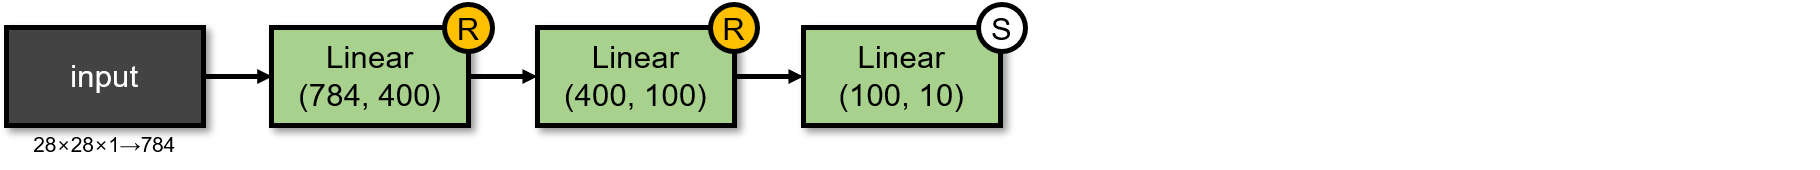

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(in_features=784, out_features=400)
    self.layer2 = nn.Linear(in_features=400, out_features=100)
    self.layer3 = nn.Linear(in_features=100, out_features=10)

  def forward(self, x):
    batchsize = x.size(0)
    x = x.view(batchsize, -1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    out = self.layer3(x)
    return out

Train and Test the model using functions `train` and `evaluate`

  - Check training time and performance(accuracry) and compare with CNN

In [ ]:
mlp_model = MLP().to("cuda")
optimizer = optim.SGD(params=mlp_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=mlp_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(mlp_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

Compare the number of parameters between CNN and MLP
  - Check which model has more parameters  

In [ ]:
mlp_num_parameters = sum(param.numel() for param in mlp_model.parameters() if param.requires_grad)
mlp_acc = evaluate(mlp_model, testloader, device="cuda")
print('Total Number of trainable parameters of MLP: {}, Accuracy of MLP: {:.2f}%'.format(mlp_num_parameters, mlp_acc))

cnn_model = cnn_model.to("cuda")
cnn_num_parameters = sum(param.numel() for param in cnn_model.parameters() if param.requires_grad)
cnn_acc = evaluate(cnn_model, testloader, device="cuda")
print('Total Number of trainable parameters of CNN: {}, Accuracy of CNN: {:.2f}%'.format(cnn_num_parameters, cnn_acc))

###**Task 1: Construct CNN by yourself**

* **Architecture 2**
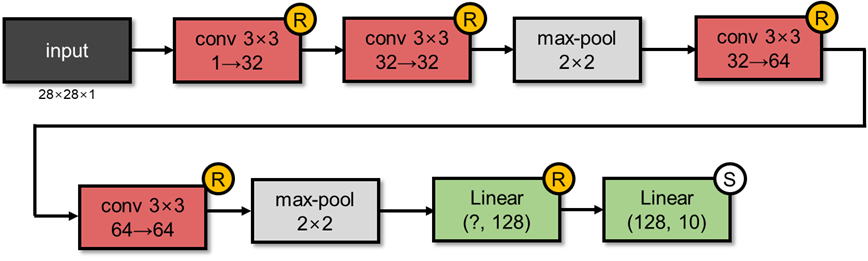

In [ ]:
class CNN2(nn.Module):
  def __init__(self):
    super(CNN2, self).__init__()
    # Construct convolutional layer    
    ############# ENTER YOUR CODE HERE #################
    




    #####################################################
       
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    ############## ENTER YOUR CODE HERE ##############
    



    
    ################################################

    out = self.fc2(x)    
    return out

Now, Let's see if you've done well.

In [ ]:
cnn_model2 = CNN2().to("cuda")
optimizer = optim.SGD(params=cnn_model2.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model2, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model2, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

##**Task 2: Improving CNN using batch-normalization**

- CNN can be stabilized by batch normailization just like MLP
- Batch normalization layer is usually applied between convolutional layer and activation function (Relu)


**Based on Architecture 1**, try to create the cnn model with batch normalization layer.

You should use `nn.Batchnorm2d(# of channel)` for CNN because the output of CNN is 2D×(# of channel)

In [ ]:
class CNN_BN(nn.Module):
  def __init__(self):
    super(CNN_BN, self).__init__()
    # Fill in the blank
    ##################################################




         
    #####################################################

    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.bn3 = nn.BatchNorm1d(128)
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    batchsize = x.size(0)
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Convolutional layer -> BN -> ReLU activation -> max_pooling
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(batchsize,-1) # Change the shape of output from [batch_size, channels, height, width] to [batch_size, channels*height*width]
    x = F.relu(self.bn3(self.fc1(x)))
    out = self.fc2(x)
    return out

In [ ]:
cnn_bn_model = CNN_BN().to("cuda")
optimizer = optim.SGD(params=cnn_bn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_bn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_bn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))